In [164]:
# PART 1: Spark aggregation to state-year (weighted rates/means)
from pyspark.sql import SparkSession, functions as F
from pathlib import Path

BASE = "/Users/compiling/435Project/Project"
COMPLETE_DIR = Path(BASE) / "complete"

spark = SparkSession.builder.appName("MicroAggregateForSklearn").getOrCreate()

micro = spark.read.parquet(str(COMPLETE_DIR / "pums_*.parquet"))
print("Total micro rows (all years):", micro.count())

weight_col = 'PWGTP'
group_cols = ['STATE_NAME', 'YEAR']
wt_sum = F.sum(weight_col)

features = [
    wt_sum.alias('state_year_population'),
    F.first('TOTAL_HEALTH_SPENDING').alias('TOTAL_HEALTH_SPENDING'),
    (F.sum(F.when(F.col('AGEP') >= 65, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_65plus_share'),
    (F.sum(F.when(F.col('AGEP') <= 17, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_0_17_share'),
    (F.sum(F.when(F.col('HICOV') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HICOV_uninsured_share'),
    (F.sum(F.when(F.col('HINS1') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS1_employer_share'),
    (F.sum(F.when(F.col('HINS4') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS4_medicaid_share'),
    (F.sum(F.col('PINCP') * F.col(weight_col)) / wt_sum).alias('PINCP_mean'),
    (F.sum(F.when(F.col('POVPIP') < 138, F.col(weight_col)).otherwise(0)) / wt_sum).alias('POVPIP_poverty_share'),
    (F.sum(F.col('VEH') * F.col(weight_col)) / wt_sum).alias('VEH_mean'),
    (F.sum(F.when(F.col('BROADBND') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('BROADBND_yes_share'),
]

print("Aggregating microdata to state-year panel ...")
df_state_year = (
    micro
    .groupBy(*group_cols)
    .agg(*features)
    .toPandas()
)
print('Final panel shape:', df_state_year.shape)
df_state_year.head()


25/12/01 15:00:16 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /Users/compiling/435Project/Project/complete/pums_*.parquet.
java.io.FileNotFoundException: File /Users/compiling/435Project/Project/complete/pums_*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(Resol

Total micro rows (all years): 15912393
Aggregating microdata to state-year panel ...
Final panel shape: (255, 13)


,STATE_NAME,YEAR,state_year_population,TOTAL_HEALTH_SPENDING,AGEP_65plus_share,AGEP_0_17_share,HICOV_uninsured_share,HINS1_employer_share,HINS4_medicaid_share,PINCP_mean,POVPIP_poverty_share,VEH_mean,BROADBND_yes_share
0,Georgia,2023,11029227,7984.0,0.153987,0.229787,0.118536,0.522321,0.188935,38810.499869,0.191753,2.146883,0.882308
1,New Jersey,2023,9290841,9676.0,0.177698,0.216073,0.071422,0.598993,0.191311,51615.316750,0.137178,1.919621,0.902386
2,Minnesota,2021,5707390,8686.0,0.168798,0.228722,0.043775,0.609255,0.188332,40836.982569,0.131647,2.168501,0.875737
3,Kansas,2023,2940547,8502.0,0.176232,0.233088,0.083518,0.573489,0.149897,37804.513519,0.166826,2.234180,0.865346
4,Utah,2021,3337975,5734.0,0.116340,0.282819,0.093118,0.633758,0.111642,34442.641509,0.127119,2.513679,0.897629


In [187]:
# PART 2: Pooled RF model (per-capita target, shuffled split)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Verify target uniqueness per state-year
leakage_counts = df_state_year.groupby(['STATE_NAME', 'YEAR'])['TOTAL_HEALTH_SPENDING'].nunique()
print('Target nunique per state-year:')
print(leakage_counts.value_counts().sort_index())
print('Summary:')
print(leakage_counts.describe())

target = 'TOTAL_HEALTH_SPENDING'  # per-capita dollars
categorical_cols = []  # drop STATE_NAME for pooled drivers
numeric_cols = [c for c in df_state_year.columns if c not in {target, 'STATE_NAME', 'ST', 'state_year_population'}]

X = df_state_year[categorical_cols + numeric_cols]
y = df_state_year[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f'Training on {len(X_train)} samples, Testing on {len(X_test)} samples')

preprocess = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
])

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    n_jobs=-1,
    random_state=42,
)

pipe = Pipeline([('pre', preprocess), ('rf', rf)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test R^2 : {r2:,.3f}')
print(f'Test MAE : {mae:,.2f}')
print(f'Test RMSE: {rmse:,.2f}')


Target nunique per state-year:
TOTAL_HEALTH_SPENDING
1    255
Name: count, dtype: int64
Summary:
count    255.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: TOTAL_HEALTH_SPENDING, dtype: float64
Training on 204 samples, Testing on 51 samples
Test R^2 : 0.636
Test MAE : 670.05
Test RMSE: 881.36


In [166]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [129]:
# scikit-optimize install (run manually if needed):
# %pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-optimize]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [186]:
# XGBoost baseline model


xgb_available = True
try:
    from xgboost import XGBRegressor
except Exception as e:
    print('XGBoost not available:', e)
    xgb_available = False

if xgboost_available := xgb_available:
    X = df_state_year[numeric_cols]
    y = df_state_year[target]
    X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    xgb = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        objective='reg:squarederror',
    )

    xgb.fit(X_train_x, y_train_x)

    for name, yt, yp in [('Train', y_train_x, xgb.predict(X_train_x)), ('Test', y_test_x, xgb.predict(X_test_x))]:
        rmse = root_mean_squared_error(yt, yp)
        mae = mean_absolute_error(yt, yp)
        r2 = r2_score(yt, yp)
        print(f"{name} -> RMSE: {rmse:,.2f}  MAE: {mae:,.2f}  R^2: {r2:.3f}")

    xgb_baseline_model = xgb
    y_pred_xgb = xgb.predict(X_test_x)
else:
    print('Skipping XGBoost baseline; xgboost not available in this environment')


Train -> RMSE: 0.29  MAE: 0.22  R^2: 1.000
Test -> RMSE: 787.85  MAE: 588.69  R^2: 0.710


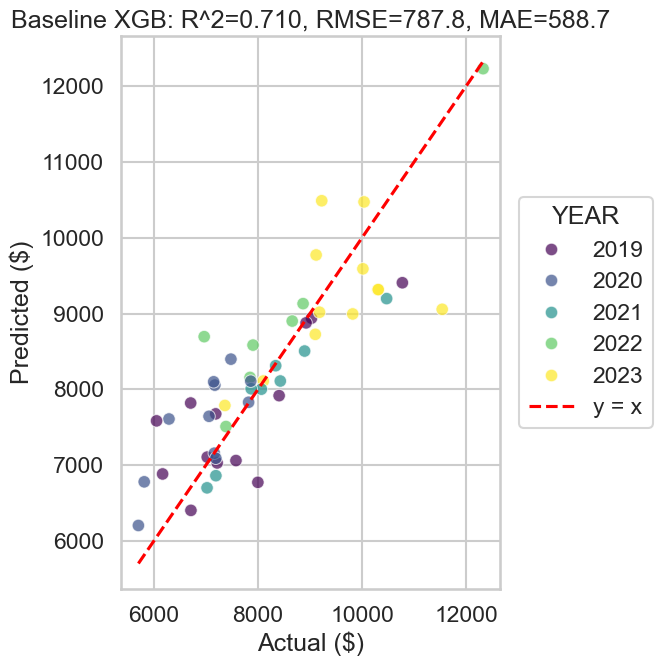

In [194]:
sns.set_theme(style="whitegrid", context="talk")

if 'xgb_baseline_model' in globals() and xgb_available:
    rmse = root_mean_squared_error(y_test_x, y_pred_xgb)
    mae = mean_absolute_error(y_test_x, y_pred_xgb)
    r2 = r2_score(y_test_x, y_pred_xgb)
    plt.figure(figsize=(7,7))
    sns.scatterplot(x=y_test_x, y=y_pred_xgb,
                    hue=X_test_x['YEAR'] if 'YEAR' in X_test_x else None,
                    palette='Blues', alpha=0.7)
    lo, hi = min(y_test_x.min(), y_pred_xgb.min()), max(y_test_x.max(), y_pred_xgb.max())
    plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
    plt.xlabel('Actual ($)')
    plt.ylabel('Predicted ($)')
    plt.title(f'Baseline XGB: R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f}')
    plt.legend(title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()
else:
    print('XGB baseline not available in this environment')


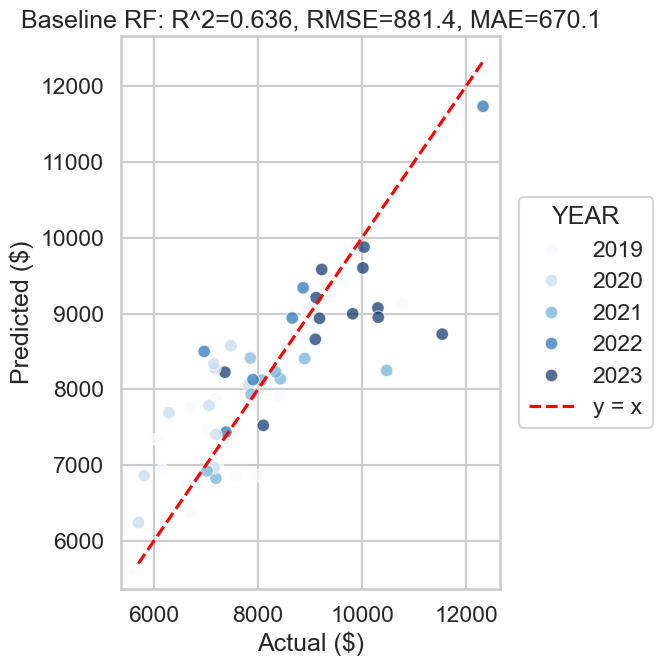

In [197]:
sns.set_theme(style="whitegrid", context="talk")

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred,
                hue=X_test['YEAR'] if 'YEAR' in X_test else None,
                palette='Blues', alpha=0.7)
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual ($)')
plt.ylabel('Predicted ($)')
plt.title(f'Baseline RF: R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f}')
plt.legend(title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.tight_layout()
plt.show()
